In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True,
                                  shear_range=True,
                                  rotation_range=40,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2
                                )
training_set = train_datagen.flow_from_directory('../input/fruit-and-vegetable-image-recognition/train',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 3115 images belonging to 36 classes.


In [4]:
val_datagen = ImageDataGenerator(rescale=1/255.)

validation_set = val_datagen.flow_from_directory('../input/fruit-and-vegetable-image-recognition/validation',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 351 images belonging to 36 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_set = test_datagen.flow_from_directory('../input/fruit-and-vegetable-image-recognition/test',
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='categorical')

Found 359 images belonging to 36 classes.


In [6]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [7]:
model = Sequential()

model.add(Conv2D(filters=32,activation='relu',kernel_size=(3,3),input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,activation='relu',kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=36,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
model.summary()

2022-09-30 08:47:47.533378: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)       0

In [8]:
from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model

In [9]:
resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(64,64,3))

for layer in resnet_v2.layers:
    layer.trainable = False
    
base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

171327488/171317808 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________

In [10]:
es = EarlyStopping(monitor='val_accuracy',patience=90,verbose=1,mode='max')
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,min_lr=0.001,patience=15,mode='max',verbose=1)

r = model.fit(training_set,
              epochs=100,
              batch_size=32,
              validation_data=validation_set,
              callbacks=[es,mc,lr])

2022-09-30 08:47:53.393689: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
98/98 [==============================] - 250s 2s/step - loss: 3.1100 - accuracy: 0.2327 - val_loss: 1.7509 - val_accuracy: 0.4729

Epoch 00001: val_accuracy improved from -inf to 0.47293, saving model to checkpoint/


2022-09-30 08:52:25.674182: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
98/98 [==============================] - 206s 2s/step - loss: 2.4024 - accuracy: 0.3352 - val_loss: 1.5872 - val_accuracy: 0.5499

Epoch 00002: val_accuracy improved from 0.47293 to 0.54986, saving model to checkpoint/
Epoch 3/100
98/98 [==============================] - 202s 2s/step - loss: 2.2003 - accuracy: 0.3917 - val_loss: 1.3484 - val_accuracy: 0.6097

Epoch 00003: val_accuracy improved from 0.54986 to 0.60969, saving model to checkpoint/
Epoch 4/100
98/98 [==============================] - 218s 2s/step - loss: 2.1039 - accuracy: 0.4212 - val_loss: 1.2146 - val_accuracy: 0.6524

Epoch 00004: val_accuracy improved from 0.60969 to 0.65242, saving model to checkpoint/
Epoch 5/100
98/98 [==============================] - 203s 2s/step - loss: 1.9732 - accuracy: 0.4546 - val_loss: 1.1963 - val_accuracy: 0.7009

Epoch 00005: val_accuracy improved from 0.65242 to 0.70085, saving model to checkpoint/
Epoch 6/100
98/98 [==============================] - 203s 2s/step - loss: 1.

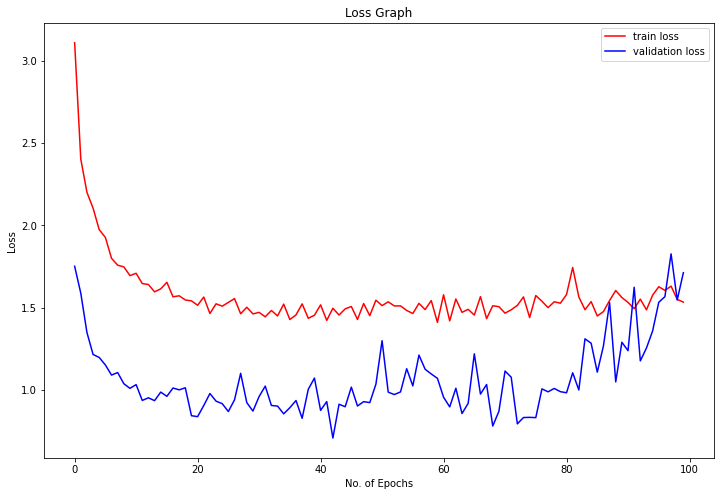

In [11]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

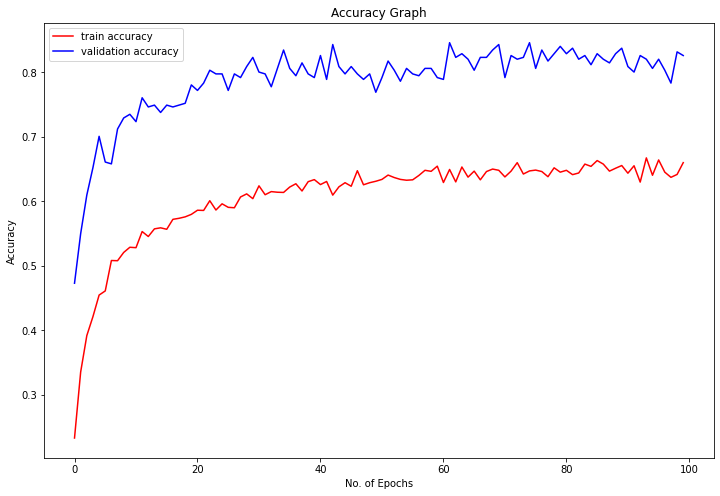

In [12]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [13]:
model.evaluate(test_set)

12/12 [==============================] - 31s 3s/step - loss: 1.6818 - accuracy: 0.8273


[1.6817870140075684, 0.8272980451583862]

In [14]:
model.save('fruits_vegetables_detector.h5')

In [15]:
cnn = load_model('fruits_vegetables_detector.h5')
cnn